# Atividade Integradora

# Road Map

## Recomendação: business bem avaliado que o usuário não foi

* bz: - **ok**
       - explodir atributos e horas de funcionamento
       - tratar atributos - selecionar os que fazem sentido e transforar true ou false para dummy
       - rodar um [k-means](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=kmeans#pyspark.ml.clustering.KMeans) na base
       - criar uma lista de business_id e no do cluster (cluster_bz)
       (- join horários mais frequentados pela base de check-in)
       
       - ordenar business por nota


* usr (Rafa) -  **ok**
       - hclust de usuários para traçar perfil comum (perfil_usr)
       - identificar usuários mais engajados/populares/com reviews mais bem avaliadas (cluster_usr)
       - entender 'elite'
       - verificar rede de amigos - matriz de distância pela lista de amigos
       
* rv:
        - Join a lista de cluster_bz na base pelo business_id
        - Join lista de cluster de usuários (perfil_usr)
        - Juntar atributos das tips na base: contagem, compliments, se teve ou não tips
        - Text mining nas reviews/tip para encontrar as palavras com maior frequência em cada cluster_bz  e cluster_usr
        - Lista com palavras mais frequentes e nota média por cluster_bz
        (- Comparar horário dos reveiws com quantidade de check-ins no estabelecimento)
        - avaliar evolução das notas por cluster_bz e por perfil de usuário (cluster_usr)
        - filtrar apenas usuários que fazem mais reviews?

        
* base final:

## Algoritmo para Recomendação (rascunho)
usuário ---> classificado no cluster
- buscar clusters de business mais bem avaliados pelo cluster do usuário
- selecionar cluster mais bem avaliado
- filtrar estabelecimentos que o usuário ainda não foi (não tem review)
- selecionar os 5 mais bem avaliados para a recomendação


* modelo:
    - input dos dados do perfil usuário + reviews realizadas + restaurantes frequentados
    - output: número do cluster de restaurantes filtrado com os não frequentados


# Ambiente Spark

In [3]:
import findspark as fs
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from pyspark.ml.feature import StopWordsRemover
import pandas as pd
import seaborn as sns
sns.set(style="ticks", palette="pastel")
import os
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#MAC Local (Viviane)
spark_location='/Users/vivi/server/spark' # Set your own
java8_location= '/Library/Java/JavaVirtualMachines/jdk1.8.0_251.jdk/Contents/Home/' # Set your own
os.environ['JAVA_HOME'] = java8_location
fs.init(spark_home=spark_location)

In [4]:
#datapath = 'C:\\Users\\RuWindows\\Desktop\\PI\\yelp_dataset\\' #Marcelo
#datapath = '../data/yelp' #servidor AWS
datapath = 'data' #Viviane

In [5]:
files = sorted(os.listdir(datapath))
files

['.DS_Store',
 'dataset list.rtf',
 'yelp_academic_dataset_business.json',
 'yelp_academic_dataset_checkin.json',
 'yelp_academic_dataset_review.json',
 'yelp_academic_dataset_tip.json',
 'yelp_academic_dataset_user.json']

In [6]:
#!head data/yelp_academic_dataset_review.json

In [7]:
# Spark Session
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('Integradora Yelp') \
    .config("spark.ui.port", "4060") \
    .getOrCreate()

**AWS**

spark = SparkSession.builder \
            .master('local[8]') \
            .appName('Yelp Integradora') \
            .getOrCreate()

In [8]:
sc = spark.sparkContext

In [9]:
spark#.stop()

## Importando as Bases Origem - Raw

In [87]:
usr_raw = spark.read.json(datapath+'/yelp_academic_dataset_user.json')
rv_raw = spark.read.json(datapath+'/yelp_academic_dataset_review.json')
bz_raw = spark.read.json(datapath+'/yelp_academic_dataset_business.json')
tp_raw = spark.read.json(datapath+'/yelp_academic_dataset_tip.json')
ch_raw = spark.read.json(datapath+'/yelp_academic_dataset_checkin.json')

In [11]:
bz_raw.createOrReplaceTempView('bz_raw')
rv_raw.createOrReplaceTempView('rv')
usr_raw.createOrReplaceTempView('usr')

In [12]:
# Visualizando Estrutura
bz_raw.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [13]:
# Verificando o SQL
print(spark.catalog.listTables())

[Table(name='bz', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='rv', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='usr', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [15]:
# bz_raw.columns

In [16]:
# usr_raw.columns

In [17]:
# rv_raw.columns

In [18]:
# tp_raw.columns

# Tratamento das bases

## Check-ins

- Explosão das datas na base

In [14]:
ch = ch_raw.withColumn('dt', f.explode(f.split(f.col('date'),', ')))

In [139]:
ch_raw.show()

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|--1UhMGODdWsrMast...|2016-04-26 19:49:...|
|--6MefnULPED_I942...|2011-06-04 18:22:...|
|--7zmmkVg-IMGaXbu...|2014-12-29 19:25:...|
|--8LPVSo5i0Oo61X0...| 2016-07-08 16:43:30|
|--9QQLMTbFzLJ_oT-...|2010-06-26 17:39:...|
|--9e1ONYQuAa-CB_R...|2010-02-08 05:56:...|
|--DaPTJW3-tB1vP-P...|2012-06-03 17:46:...|
|--DdmeR16TRb3LsjG...|2012-11-02 21:26:...|
|--EF5N7P70J_UYBTP...|2018-05-25 19:52:...|
|--EX4rRznJrltyn-3...|2010-02-26 17:05:...|
|--FBCX-N37CMYDfs7...|2010-05-31 07:57:...|
|--FLdgM0GNpXVMn74...|2012-10-23 18:47:...|
|--FnvijzY20d1nk9H...|2019-09-19 02:42:...|
|--GM_ORV2cYS-h38D...|2011-09-11 18:16:...|
|--I7YYLada0tSLkOR...|2014-11-07 00:51:...|
|--KCl2FvVQpvjzmZS...|2011-07-29 16:53:...|
|--KQsXc-clkO7oHRq...|2010-05-02 23:57:...|
|--Ni3oJ4VOqfOEu7S...| 2019-06-07 17:54:58|
|--Rsj71PBe31h5Ylj...|2011-12-15 18:09:...|
|--S62v0QgkqQaVUhF...|2010-12-25

In [15]:
ch.createOrReplaceTempView('ch')

In [16]:
ch1 = spark.sql('''
            SELECT business_id, dt,
            DATE(dt) AS date,
            DAYOFWEEK(dt) AS dow,
            MONTH(dt) AS month,
            YEAR(dt) AS year,
            HOUR(dt) AS hour,
            DAY(dt) AS day
            
            FROM ch
            
            ''')

In [141]:
ch1.show()

+--------------------+-------------------+----------+---+-----+----+----+---+
|         business_id|                 dt|      date|dow|month|year|hour|day|
+--------------------+-------------------+----------+---+-----+----+----+---+
|--1UhMGODdWsrMast...|2016-04-26 19:49:16|2016-04-26|  3|    4|2016|  19| 26|
|--1UhMGODdWsrMast...|2016-08-30 18:36:57|2016-08-30|  3|    8|2016|  18| 30|
|--1UhMGODdWsrMast...|2016-10-15 02:45:18|2016-10-15|  7|   10|2016|   2| 15|
|--1UhMGODdWsrMast...|2016-11-18 01:54:50|2016-11-18|  6|   11|2016|   1| 18|
|--1UhMGODdWsrMast...|2017-04-20 18:39:06|2017-04-20|  5|    4|2017|  18| 20|
|--1UhMGODdWsrMast...|2017-05-03 17:58:02|2017-05-03|  4|    5|2017|  17|  3|
|--1UhMGODdWsrMast...|2019-03-19 22:04:48|2019-03-19|  3|    3|2019|  22| 19|
|--6MefnULPED_I942...|2011-06-04 18:22:23|2011-06-04|  7|    6|2011|  18|  4|
|--6MefnULPED_I942...|2011-07-23 23:51:33|2011-07-23|  7|    7|2011|  23| 23|
|--6MefnULPED_I942...|2012-04-15 01:07:50|2012-04-15|  1|    4|2

In [17]:
ch1.createOrReplaceTempView('ch1')

In [18]:
ch2 = spark.sql('''
            SELECT  business_id, year, month, dow, day,
                    COUNT(date) AS count
            
            FROM ch1
            
            GROUP BY business_id, year, month, dow, day
            ORDER BY count DESC
                 
            ''')

In [19]:
ch2.createOrReplaceTempView('ch2')

### Analisando o movimento de um estabelecimento

In [20]:
df = spark.sql('''
            SELECT *
            FROM ch2

            WHERE business_id = 'BxCzy1WOVxOrr_G7V4BIvg'
            
            ''').toPandas()

In [21]:
df2 = df.groupby(['month','dow'])['count'].sum().unstack('dow').fillna(0)   

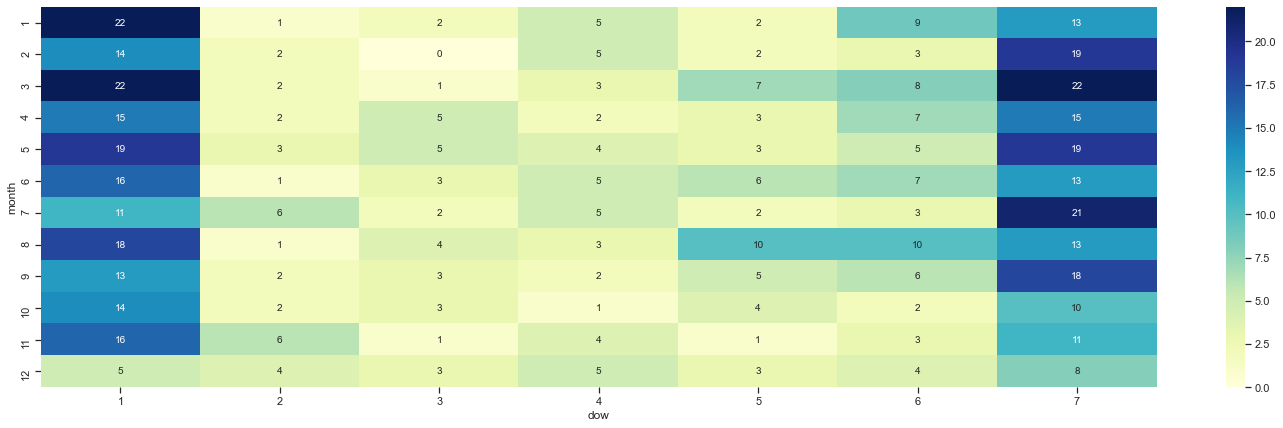

In [22]:
plt.figure(figsize = (25,7))
sns.heatmap(data = df2, cmap="YlGnBu", annot = True)

Pelo gráfico, verfica-se que o local é ais movimentado em janeiro, principalmente aos finais de semana. Para simplicar, será utilzada a média de checkins dos estabelecimentos.

### Média de movimento diário por estabelecimento

In [46]:
ch2.show(5)

+--------------------+----+-----+---+---+-----+
|         business_id|year|month|dow|day|count|
+--------------------+----+-----+---+---+-----+
|RESDUcs7fIiihp38-...|2019|   10|  1|  6|  288|
|K2PHx0JgNuZh7b89g...|2017|    7|  7| 15|  264|
|RESDUcs7fIiihp38-...|2019|    9|  1|  1|  263|
|RESDUcs7fIiihp38-...|2019|   10|  7|  5|  261|
|RESDUcs7fIiihp38-...|2019|    8|  7| 31|  246|
+--------------------+----+-----+---+---+-----+
only showing top 5 rows



In [48]:
ch3 = spark.sql('''
            SELECT  business_id,
                    avg(count) AS avg_frequency
            
            FROM ch2
            WHERE year >= 2017
            GROUP BY business_id
            ORDER BY avg_frequency DESC

            
            ''')

In [49]:
ch3.show()

+--------------------+------------------+
|         business_id|     avg_frequency|
+--------------------+------------------+
|_GdzDB3SU9Ni7mAOQ...|             106.0|
|ndjiWXoH1pPMwEBhR...|              87.0|
|K2PHx0JgNuZh7b89g...| 65.36363636363636|
|33Pq0cQn3jODiIG7V...| 56.46969696969697|
|saOyWIFTUHGMhRnGT...|              53.0|
|XZSrcXW0AWOUC1QOx...|38.142857142857146|
|FaHADZARwnY4yvlvp...|30.924791086350975|
|YpW8DmVDddFy_BSN1...|              30.5|
|8isOf2XrhPnWqIpW5...|              29.0|
|hihud--QRriCYZw1z...|28.071494893221914|
|vL-B-BmNQWULt-chn...|              26.0|
|JmI9nslLD7KZqRr__...|25.542246982358403|
|TPiYeUu9ICo_VYLE1...| 25.11111111111111|
|QXV3L_QFGj8r6nWX2...|24.516248839368618|
|VXOS-q3-YgmgLXQE5...|              24.0|
|k4LqVGsdvcBDrQHo6...|              23.0|
|RESDUcs7fIiihp38-...| 22.03004694835681|
|ca1lyR65KPrjuSS50...|              22.0|
|Cu5oU2dO3JCEQ4XHK...|21.666666666666668|
|7PWUo0_T_1Il0CqSp...|              21.0|
+--------------------+------------

In [50]:
ch3.createOrReplaceTempView('ch3')

A média diária de check-ins será juntada na base final para modelagem

## Tips

In [93]:
tp_raw.createOrReplaceTempView('tp')

In [94]:
tp_raw.show()

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|UYX5zL_Xj9WEc_Wp-...|               0|2013-11-26 18:20:08|Here for a quick mtg|hf27xTME3EiCp6NL6...|
|Ch3HkwQYv1YKw_FO0...|               0|2014-06-15 22:26:45|Cucumber strawber...|uEvusDwoSymbJJ0au...|
|rDoT-MgxGRiYqCmi0...|               0|2016-07-18 22:03:42|Very nice good se...|AY-laIws3S7YXNl_f...|
|OHXnDV01gLokiX1EL...|               0|2014-06-06 01:10:34|It's a small plac...|Ue_7yUlkEbX4AhnYd...|
|GMrwDXRlAZU2zj5nH...|               0|2011-04-08 18:12:01|8 sandwiches, $24...|LltbT_fUMqZ-ZJP-v...|
|ALwAlxItASeEs2vYA...|               0|2015-05-20 20:17:38|Great ramen! Not ...|HHNBqfbDR8b1iq-QG...|
|d_L-rfS1vT3JMzgCU...|               0|2014-09-01 01:23:48|Cochinita Pibil w...|r0

- Quantidade de tips por estabelecimento e usuário

In [132]:
tp_usr = spark.sql('''
            SELECT user_id, 
            count(text) AS tips_counter,
            sum(compliment_count) as total_compliments
            
            FROM tp
            
            GROUP BY user_id
            ORDER BY total_compliments DESC
            ''')

In [133]:
tp_usr.show()

+--------------------+------------+-----------------+
|             user_id|tips_counter|total_compliments|
+--------------------+------------+-----------------+
|mkbx55W8B8aPLgDqe...|        2664|             1358|
|zFYs8gSUYDvXkb6O7...|         453|              196|
|0tvCcnfJnSs55iB6m...|        1602|              165|
|R5WcogaoAwjdHxrB2...|         497|              162|
|A0j21z2Q1HGic7jW6...|        1005|              159|
|eZfHm0qI8A_HfvXSc...|        1376|              126|
|2EuPAGalYnP7eSxPg...|        1186|              122|
|CxDOIDnH8gp9KXzpB...|        1673|              115|
|fZY97UjlP-iv35beO...|         330|              107|
|Fv0e9RIV9jw5TX3ct...|         249|              101|
|0FMte0z-repSVWSJ_...|         950|              101|
|3nDUQBjKyVor5wV0r...|        1018|               94|
|u_wqt9RshdZsoj8ik...|         385|               86|
|8DEyKVyplnOcSKx39...|         102|               85|
|uG35h72BAMutvXAWd...|         848|               80|
|dt9IHwfuZs9D9LOH7...|      

In [100]:
tp_bz = spark.sql('''
            SELECT business_id, 
            count(text) AS tips_counter,
            sum(compliment_count) as total_compliments
            
            FROM tp
            
            GROUP BY business_id
            ORDER BY total_compliments DESC
            ''')

In [101]:
tp_bz.createOrReplaceTempView('tp_bz')

In [105]:
tp_bz.show()

+--------------------+------------+-----------------+
|         business_id|tips_counter|total_compliments|
+--------------------+------------+-----------------+
|BQqwIYQuo2W94smjr...|         128|               68|
|FaHADZARwnY4yvlvp...|        3679|               55|
|RESDUcs7fIiihp38-...|        1386|               54|
|55E0-qUHa7Kzqz8rO...|         329|               40|
|DN0b4Un8--Uf6SEWL...|         328|               36|
|QhXBIQWUmQxuVErdw...|          76|               36|
|JmI9nslLD7KZqRr__...|        2494|               35|
|MpmFFw0GE_2iRFPds...|         696|               35|
|QsKhwKYB3YeWXqpIP...|          78|               31|
|DfgZlNgKwBvCpA_0a...|         442|               31|
|OMRYQihVjqqzjoNoQ...|         101|               30|
|awI4hHMfa7H0Xf0-C...|         745|               28|
|X8c23dur0ll2D9XTu...|         298|               26|
|O7UMzd3i-Zk8dMeyY...|         240|               26|
|t-o_Sraneime4DDhW...|         648|               24|
|iCQpiavjjPzJ5_3gP...|      

## Business

### Abertura dos atributos e horários para colunas

In [51]:
dfs = []

for x in ["hours", "attributes"]:
    cols = bz_raw.select(f"{x}.*").columns
    for col in cols:
        try:
            dfs.append(dfs[-1].withColumn(col, f.col(f"{x}.{col}")))
        except IndexError:
            dfs.append(bz_raw.withColumn(col, f.col(f"{x}.{col}")))
            
bz = dfs[-1].drop("hours", "attributes")  
bz.createOrReplaceTempView("bz")
bz.printSchema()

root
 |-- address: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)
 |-- Friday: string (nullable = true)
 |-- Monday: string (nullable = true)
 |-- Saturday: string (nullable = true)
 |-- Sunday: string (nullable = true)
 |-- Thursday: string (nullable = true)
 |-- Tuesday: string (nullable = true)
 |-- Wednesday: string (nullable = true)
 |-- AcceptsInsurance: string (nullable = true)
 |-- AgesAllowed: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Ambience: string (nullable = true)
 |-- BYOB: string (nullable = true)
 |-- BYOBCorkage: string (nullable = true)

### Limpeza e padronização dos atributos

In [52]:
bz1 = spark.sql('''
                SELECT *
                FROM bz
                WHERE city == 'Toronto' 
                AND is_open == 1
                ''')

In [53]:
bz1.groupBy('is_open').count().show()

+-------+-----+
|is_open|count|
+-------+-----+
|      1|14962|
+-------+-----+



In [54]:
cols = bz_raw.select('attributes.*').columns

- Valores únicos em cada coluna de atributos. As colunas que contém listas serão desconsideradas da base para facilitar a análise. As demais serão codificadas conforme a seguir:

    - Null/None: 0
    - False: 1
    - True: 2
    
As colunas que possuem uma descrição das características serão tratadas individualmente.

In [55]:
[bz1.groupBy(cols[x]).count().show() for x in range(len(cols))]

+----------------+-----+
|AcceptsInsurance|count|
+----------------+-----+
|            None|    2|
|           False|   97|
|            null|14531|
|            True|  332|
+----------------+-----+

+-----------+-----+
|AgesAllowed|count|
+-----------+-----+
|       null|14954|
| u'allages'|    1|
|  u'19plus'|    7|
+-----------+-----+

+----------------+-----+
|         Alcohol|count|
+----------------+-----+
|            None|    5|
|         u'none'| 1398|
|            null|10876|
| 'beer_and_wine'|  127|
|          'none'|  358|
|u'beer_and_wine'|  445|
|     u'full_bar'| 1599|
|      'full_bar'|  154|
+----------------+-----+

+--------------------+-----+
|            Ambience|count|
+--------------------+-----+
|{'touristy': None...|    1|
|{'touristy': None...|    1|
|{'touristy': Fals...|    1|
|{'touristy': Fals...|    1|
|{'touristy': Fals...|   13|
|{'touristy': Fals...|    1|
|{'touristy': Fals...|   15|
|{'touristy': Fals...|    1|
|{'touristy': None...|    1|
|{'touris

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [56]:
unwanted = ['Ambience','BestNights','BusinessAcceptsBitcoin','BusinessParking','BYOBCorkage','DietaryRestrictions','GoodForMeal','HairSpecializesIn','Music','Open24Hours','RestaurantsCounterService']

In [57]:
bz2 = bz1.drop('Ambience','BestNights','BusinessAcceptsBitcoin','BusinessParking','BYOBCorkage','DietaryRestrictions','GoodForMeal','HairSpecializesIn','Music','Open24Hours','RestaurantsCounterService',
              'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','address','postal_code','state','city','is_open')

In [58]:
for col in unwanted:
    cols.remove(col)

In [59]:
bz3 = bz2.fillna('0')

In [60]:
bz4 = bz3.replace({'True':'2', 'False':'1','None':'0','null':'0'}, cols)

/Users/vivi/anaconda3/lib/python3.7/site-packages/pyspark/sql/dataframe.py:1800: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [61]:
bz5 = bz4.withColumn('AgesAllowed',f.regexp_replace(f.col('AgesAllowed'), "u'allages'",'0'))
bz6 = bz5.withColumn('AgesAllowed',f.regexp_replace(f.col('AgesAllowed'), "u'19plus'",'19'))

In [62]:
bz7 = bz6.withColumn('Alcohol',f.regexp_replace(f.col('Alcohol'), "'none'|u'none'",'0'))
bz8 = bz7.withColumn('Alcohol',f.regexp_replace(f.col('Alcohol'), "'beer_and_wine'|u'beer_and_wine'",'1'))
bz9 = bz8.withColumn('Alcohol',f.regexp_replace(f.col('Alcohol'), "'full_bar'|u'full_bar'",'2'))

In [63]:
bz10 = bz9.withColumn('NoiseLevel',f.regexp_replace(f.col('NoiseLevel'), "'quiet'|u'quiet'",'1'))
bz11 = bz10.withColumn('NoiseLevel',f.regexp_replace(f.col('NoiseLevel'), "'average'|u'average'",'2'))
bz12 = bz11.withColumn('NoiseLevel',f.regexp_replace(f.col('NoiseLevel'), "'very_loud'|u'very_loud'",'4'))
bz13 = bz12.withColumn('NoiseLevel',f.regexp_replace(f.col('NoiseLevel'), "'loud'|u'loud'",'3'))

In [64]:
bz14 = bz13.withColumn('Smoking',f.regexp_replace(f.col('Smoking'), "'no'|u'no'",'1'))
bz15 = bz14.withColumn('Smoking',f.regexp_replace(f.col('Smoking'), "'outdoor'|u'outdoor'",'2'))
bz16 = bz15.withColumn('Smoking',f.regexp_replace(f.col('Smoking'), "'yes'|u'yes'",'3'))

In [65]:
bz17 = bz16.withColumn('WiFi',f.regexp_replace(f.col('WiFi'), "'no'|u'no'",'1'))
bz18 = bz17.withColumn('WiFi',f.regexp_replace(f.col('WiFi'), "'paid'|u'paid'",'2'))
bz19 = bz18.withColumn('WiFi',f.regexp_replace(f.col('WiFi'), "'free'|u'free'",'3'))

In [66]:
bz20 = bz19.withColumn('RestaurantsAttire',f.regexp_replace(f.col('WiFi'), "'casual'|u'casual'",'1'))
bz21 = bz20.withColumn('RestaurantsAttire',f.regexp_replace(f.col('WiFi'), "'dressy'|u'dressy'",'2'))
bz22 = bz21.withColumn('RestaurantsAttire',f.regexp_replace(f.col('WiFi'), "'formal'|u'formal'",'3'))

In [67]:
#[bz22.groupBy(cols[x]).count().show() for x in range(len(cols))]

In [68]:
bz22.createOrReplaceTempView('bz22')

### Join da média diária de check-ins

In [136]:
ch3.columns

['business_id', 'avg_frequency']

In [137]:
bz23 = spark.sql('''
                SELECT A.*,
                B.avg_frequency
                
                FROM bz22 as A
                LEFT JOIN ch3 as B
                ON A.business_id = B.business_id
                
                ''')

In [ ]:
bz23.createOrReplaceTempView('bz23')

### Join da quantidade de tips por estabelecimento

In [102]:
bz24 = spark.sql('''
                SELECT A.*,
                B.tips_counter,
                B.total_compliments
                
                FROM bz23 as A
                LEFT JOIN tp_bz as B
                ON A.business_id = B.business_id
                
                ''')

In [104]:
bz23.columns

['business_id',
 'categories',
 'latitude',
 'longitude',
 'name',
 'review_count',
 'stars',
 'AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'BYOB',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'HappyHour',
 'HasTV',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi',
 'tips_counter',
 'total_compliments']

In [106]:
bz24.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp_bz.csv')

In [117]:
bz24.createOrReplaceTempView('bz')

## Users

### Seleção e tratamento da variáveis

In [118]:
# Transforma variáveis para serem utilizadas na Matriz de Distâncias - H Clust
# Arrays em Numéricas - "id" de friends para friends_count
# Arrays em Numéricas - "ano" de elite para elite_count
# Data em Numéricas do ano - "yelping_since" para "year_since"

from pyspark.sql.functions import col, count, explode, split, array
from pyspark.sql.types import ArrayType, IntegerType

usr_raw1 = usr_raw.withColumn('friends_count', f.size(f.split(f.col('friends'), ' ')))
usr_raw1 = usr_raw1.withColumn('elite_count', f.size(f.split(f.col('elite'), ',')))
usr_raw1 = usr_raw1.withColumn('year_since', f.year('yelping_since'))

#usr_raw1.show()

In [109]:
usr_raw1.createOrReplaceTempView('usr_raw1')

- Seleção variáveis que serão utilizadas na clusterização

In [119]:
usr_base = spark.sql('''
            SELECT 
            
            A.user_id,
            A.average_stars,
            A.compliment_cool,
            A.compliment_cute,
            A.compliment_funny,
            A.compliment_hot,
            A.compliment_list,
            A.compliment_more,
            A.compliment_note,
            A.compliment_photos,
            A.compliment_plain,
            A.compliment_profile,
            A.compliment_writer,
            A.cool,
            A.elite_count,
            A.fans,
            A.friends_count,
            A.funny,
            A.review_count as review_count_usr,
            A.useful,
            A.year_since,
            B.business_id

            FROM usr_raw1  as A LEFT JOIN rv as B
            
            ON A.user_id = B.user_id
            
            ''')

In [111]:
usr_base.createOrReplaceTempView('usr_base')

In [112]:
spark.sql('''
            SELECT 
            COUNT(DISTINCT user_id)
            FROM usr_base
            ''').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                1968703|
+-----------------------+



- Seleção de usuários com reviews de business IDs em Toronto, já selecionados anteriormente na base de estabelecimentos

In [122]:
usr_base2 = spark.sql('''
            SELECT 
            A.business_id,
            B.*

            FROM bz as A 
            LEFT JOIN usr_base as B
            
            ON A.business_id = B.business_id
                      
            ''')

In [123]:
usr_base2.createOrReplaceTempView('usr_base2')

In [124]:
spark.sql('''
            SELECT 
            COUNT(DISTINCT user_id)
            FROM usr_base2
            ''').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 119792|
+-----------------------+



In [125]:
# Identificar User_id Apenas de Usuários que fizeram Reviews em Estabelecimentos Abertos Em Toronto

usr_base3 = spark.sql('''
            SELECT 
            DISTINCT user_id
            FROM usr_base2
            ''')

In [126]:
usr_base3.createOrReplaceTempView('usr_base3')

In [127]:
# Seleciona Apenas de Usuários que fizeram Reviews em Estabelecimentos Abertos Em Toronto

usr_base4 = spark.sql('''
            SELECT 
            A.user_id,
            A.average_stars,
            A.compliment_cool,
            A.compliment_cute,
            A.compliment_funny,
            A.compliment_hot,
            A.compliment_list,
            A.compliment_more,
            A.compliment_note,
            A.compliment_photos,
            A.compliment_plain,
            A.compliment_profile,
            A.compliment_writer,
            A.cool,
            A.elite_count,
            A.fans,
            A.friends_count,
            A.funny,
            A.review_count AS review_count_usr,
            A.useful,
            A.year_since

            FROM usr_raw1  as A LEFT JOIN usr_base3 as B
            
            ON A.user_id = B.user_id
            
            WHERE B.user_id <> ''
            
            ''')

In [128]:
usr_base4.createOrReplaceTempView('usr_base4')

- Quantidade inicial de usuários na base:

In [129]:
spark.sql('''
            SELECT 
            COUNT(DISTINCT user_id)
            FROM usr_raw1
            ''').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                1968703|
+-----------------------+



- Quantidade final de usuários na base:

In [134]:
spark.sql('''
            SELECT 
            COUNT(DISTINCT user_id)
            FROM usr_base4
            ''').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 119792|
+-----------------------+



In [83]:
usr_base4.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp_usr.csv')

In [84]:
usr_base4.columns

['user_id',
 'average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite_count',
 'fans',
 'friends_count',
 'funny',
 'review_count_usr',
 'useful',
 'year_since']

## Reviews

To dos: 

- ler arquivos de cluster e juntar na base de reviews
- Join a lista de cluster_bz na base pelo business_id
- Join lista de cluster de usuários (perfil_usr)
- Juntar atributos das tips na base: contagem, compliments, se teve ou não tips (ver código pronto na base única)
- Text mining nas reviews/tip para encontrar as palavras com maior frequência em cada cluster_bz  e cluster_usr (código pronto no R: modelagem yelp 3)
- Lista com palavras mais frequentes e nota média por cluster_bz
- avaliar evolução das notas por cluster_bz e por perfil de usuário (cluster_usr)
(- Comparar horário dos reveiws com quantidade de check-ins no estabelecimento)

In [133]:
rv1 = spark.sql("""
        SELECT 
        B.*,
        A.business_id,
        A.stars as stars_rv,
        YEAR(A.date) AS year_rv
        
        FROM usr_clusters2 as B
        LEFT JOIN rv as A
        ON B.user_id = A.user_id

        """)

In [134]:
rv1.columns

['user_id',
 'average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite_count',
 'fans',
 'friends_count',
 'funny',
 'review_count',
 'useful',
 'year_since',
 'cluster_usr',
 'business_id',
 'stars_rv',
 'year_rv']

In [135]:
rv1.createOrReplaceTempView('rv1')

In [136]:
rv2 = spark.sql("""
        SELECT A.*,
        B.cluster as cluster_usr
        
        FROM rv1 as A
        LEFT JOIN usr_clusters as B
        ON A.user_id = B.user_id

        """)

In [137]:
rv2.columns

['user_id',
 'average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite_count',
 'fans',
 'friends_count',
 'funny',
 'review_count',
 'useful',
 'year_since',
 'cluster_usr',
 'business_id',
 'stars_rv',
 'year_rv',
 'cluster_usr']

In [138]:
rv2.createOrReplaceTempView('rv2')

In [130]:
spark.sql('''
            SELECT 
            COUNT(DISTINCT user_id)
            FROM rv2
            ''').show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                1968703|
+-----------------------+



In [131]:
spark.sql('''
            SELECT 
            COUNT(DISTINCT business_id)
            FROM rv2
            ''').show()

+---------------------------+
|count(DISTINCT business_id)|
+---------------------------+
|                     209393|
+---------------------------+



In [106]:
rv3 = spark.sql("""
        SELECT A.*,
        B.*
        FROM rv2 as A 
        RIGHT JOIN bz22 as B
        ON A.business_id = B.business_id

        """)

In [107]:
rv2.columns

['business_id',
 'stars_rv',
 'user_id',
 'year_rv',
 'cluster_usr',
 'business_id',
 'categories',
 'latitude',
 'longitude',
 'name',
 'review_count',
 'stars',
 'AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'BYOB',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'HappyHour',
 'HasTV',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi']

In [59]:
rv2.createOrReplaceTempView('rv2')

In [60]:
spark.sql('''
            SELECT 
            COUNT(DISTINCT business_id)
            FROM rv2
            ''').show()

+---------------------------+
|count(DISTINCT business_id)|
+---------------------------+
|                      14962|
+---------------------------+



In [61]:
spark.sql('''
            SELECT 
            COUNT(DISTINCT review_id)
            FROM rv2
            ''').show()

+-------------------------+
|count(DISTINCT review_id)|
+-------------------------+
|                   481658|
+-------------------------+



In [62]:
rv_df = spark.sql("""
        SELECT cluster_bz, year_rv, count(review_id) as qtde_rv
        
        FROM rv2 as A
        GROUP BY cluster_bz, year_rv
        """).toPandas()

In [102]:
rv_df

,cluster_bz,year_rv,qtde_rv
0,2,2017,8433
1,4,2009,1129
2,3,2016,4518
3,3,2017,3949
4,7,2012,4555
...,...,...,...
80,7,2017,16997
81,5,2015,12672
82,1,2008,708
83,2,2018,7159


In [ ]:
#plt.figure(figsize = (25,7))
#sns.heatmap(data = df2, cmap="YlGnBu", annot = True)

In [ ]:
#df2 = df.groupby(['month','dow'])['count'].sum().unstack('dow').fillna(0) 

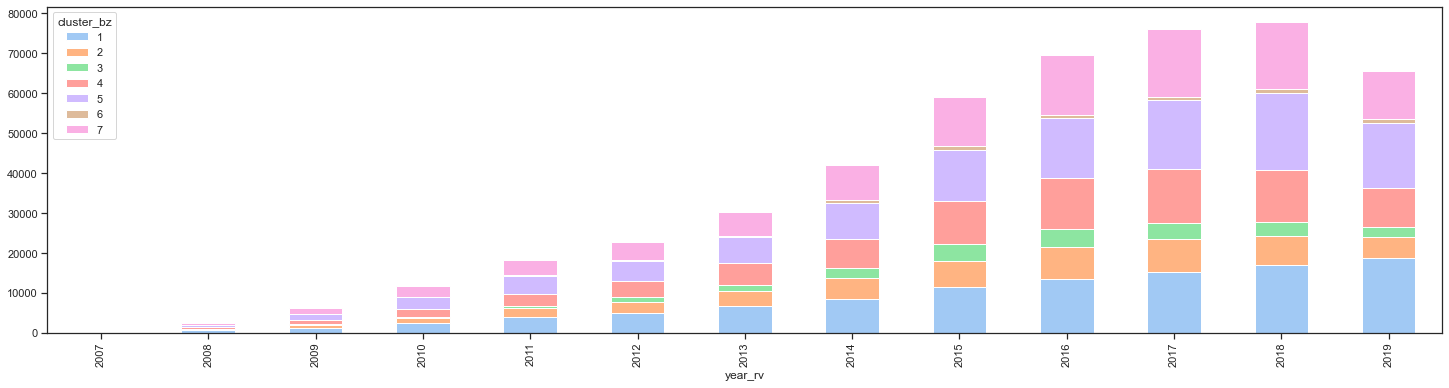

In [104]:
rv_df.groupby(['year_rv','cluster_bz'])['qtde_rv'].agg('sum').unstack('cluster_bz').plot(kind = 'bar', stacked = True, figsize = (25,6))

## Base para treino do modelo

## Tratamento do texto

In [ ]:
def word_clean(sdf,col,new_col):
    rv1 = sdf.withColumn(new_col,f.regexp_replace(f.col(col), "'d", " would"))
    rv2 = rv1.withColumn(new_col,f.regexp_replace(f.col(new_col), "'ve", " have"))
    rv3 = rv2.withColumn(new_col,f.regexp_replace(f.col(new_col), "'s", " is"))
    rv4 = rv3.withColumn(new_col,f.regexp_replace(f.col(new_col), "'re", " are"))
    rv5 = rv4.withColumn(new_col,f.regexp_replace(f.col(new_col), "n't", " not"))
    rv6 = rv5.withColumn(new_col,f.regexp_replace(f.col(new_col), '\W+', " "))
    rv7 = rv6.withColumn(new_col,f.lower(f.col(new_col)))
    return rv7

word_clean(rv,'text_rv','text_clean')
word_clean(rv,'tip','tip_clean')

In [77]:
usr_clusters = spark.read.csv('output/usr_cluster.csv', header = True)
usr_clusters.createOrReplaceTempView('usr_clusters')

In [78]:
#Juntando número do cluster na base de usuários
usr_clusters2 = spark.sql("""
                SELECT A.*,
                B.cluster as cluster_usr

                FROM usr_base4 as A
                LEFT JOIN usr_clusters as B
                ON A.user_id = B.user_id

                """)

In [ ]:
usr_clusters2.createOrReplaceTempView('usr_clusters2')

In [93]:
#seleção das reviews daqueles usuários
bf1 = spark.sql("""
        SELECT 
        B.*,
        A.business_id,
        A.stars as stars_rv,
        YEAR(A.date) AS year_rv
        
        FROM usr_clusters2 as B
        LEFT JOIN rv as A
        ON B.user_id = A.user_id

        """)

In [80]:
bf1.columns

['user_id',
 'average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite_count',
 'fans',
 'friends_count',
 'funny',
 'review_count_usr',
 'useful',
 'year_since',
 'cluster_usr',
 'business_id',
 'stars_rv',
 'year_rv']

In [82]:
bf1.createOrReplaceTempView('bf1')

In [85]:
bz22.columns

['business_id',
 'categories',
 'latitude',
 'longitude',
 'name',
 'review_count',
 'stars',
 'AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'BYOB',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'HappyHour',
 'HasTV',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi']

In [94]:
bf2 = spark.sql('''
                SELECT A.*,
                B.categories,
                B.latitude,
                B.longitude,
                B.name,
                B.review_count,
                B.stars,
                B.AcceptsInsurance,
                B.AgesAllowed,
                B.Alcohol,
                B.BYOB,
                B.BikeParking,
                B.BusinessAcceptsCreditCards,
                B.ByAppointmentOnly,
                B.Caters,
                B.CoatCheck,
                B.Corkage,
                B.DogsAllowed,
                B.DriveThru,
                B.GoodForDancing,
                B.GoodForKids,
                B.HappyHour,
                B.HasTV,
                B.NoiseLevel,
                B.OutdoorSeating,
                B.RestaurantsAttire,
                B.RestaurantsDelivery,
                B.RestaurantsGoodForGroups,
                B.RestaurantsPriceRange2,
                B.RestaurantsReservations,
                B.RestaurantsTableService,
                B.RestaurantsTakeOut,
                B.Smoking,
                B.WheelchairAccessible,
                B.WiFi
                
                FROM bf1 as A 
                RIGHT JOIN bz22 as B
                ON A.business_id = B.business_id
                
                WHERE year_rv >= 2017
                
                ''')

In [95]:
#bf1.groupBy('cluster_bz').count().show()

In [96]:
bf2.createOrReplaceTempView('bf2')

In [97]:
spark.sql('''
            SELECT 
            COUNT(DISTINCT business_id)
            FROM bf2
            ''').show()

+---------------------------+
|count(DISTINCT business_id)|
+---------------------------+
|                      13428|
+---------------------------+



In [98]:
bf2.columns

['user_id',
 'average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite_count',
 'fans',
 'friends_count',
 'funny',
 'review_count_usr',
 'useful',
 'year_since',
 'cluster_usr',
 'business_id',
 'stars_rv',
 'year_rv',
 'categories',
 'latitude',
 'longitude',
 'name',
 'review_count',
 'stars',
 'AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'BYOB',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'HappyHour',
 'HasTV',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccess

In [99]:
bf2.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp.csv')

## Tratamento do Texto

In [48]:
words = word_clean(bf2,'text','text_clean')
#base6 = word_clean(base5,'tip','tip_clean')

In [49]:
# base6.select('text_clean','tip_clean').show()

- Contagem de amigos de cada usuário

In [50]:
base7 = base6.withColumn('friends_counter_usr', f.size(f.split(f.col('friends_usr'),',')))

In [51]:
base7.createOrReplaceTempView('base7')

In [52]:
base8 = spark.sql('''
            SELECT *,
            (CASE WHEN friends_usr = 'None' THEN 0 ELSE friends_counter_usr END) as friends_count_usr
            FROM base7
            ''')

In [53]:
df = base8.select('friends_usr','friends_counter_usr','friends_count_usr').limit(10).toPandas()

In [54]:
df.dtypes

friends_usr            object
friends_counter_usr     int32
friends_count_usr       int32
dtype: object

In [55]:
df

,friends_usr,friends_counter_usr,friends_count_usr
0,"8lfS8bZkamISfRfWim5CKw, yixPLGK98f9uH1_QTRbwvg...",87,87
1,"8lfS8bZkamISfRfWim5CKw, yixPLGK98f9uH1_QTRbwvg...",87,87
2,"ALxRHdxbefyWvZ-7nbmy7Q, efZ2H4mRruo4STvSCPPqYA...",27,27
3,"ALxRHdxbefyWvZ-7nbmy7Q, efZ2H4mRruo4STvSCPPqYA...",27,27
4,"-A0mo_vdbn_-_omovpr3HA, 4jh8x7Xv6aKAiZmBRlV8OA...",57,57
5,None,1,0
6,"hD3xxj6CyunXze3sCAnDrw, QV8xDVk5AYZEpiOTI6_E0g...",73,73
7,"5e-12hnuO5qK8loS9D8o5Q, ahHKqP2-5xx2QlcJDAc3qQ...",205,205
8,"wVvjv0lOGFXvpXdNfA2WHA, lGKDN8lSn6RhTkKzQ8wwig...",11,11
9,None,1,0


In [56]:
# base8.select('friends_usr','friends_counter_usr','friends_count_usr').show()

## Concatenando Comentários por Usuário - Review + Tips

In [57]:
base9 = base8.withColumn('rv_tip', f.concat(f.col('text_clean'),f.lit(' '), f.col('tip_clean')))

In [58]:
# base9.select('text_clean','tip_clean','rv_tip','stars_rv','compliment_count_tip','funny_rv','cool_rv').show()

In [59]:
base9.createOrReplaceTempView('base9')

In [60]:
# spark.sql('''
#         SELECT stars_rv, count(tip_clean) as tip_counter
#         FROM base9
#         GROUP BY stars_rv
#         ORDER BY tip_counter DESC
#         ''').show()

- Remoção de colunas que não serão utilizadas na primeira modelagem

In [61]:
base_final = base9.drop('friends_usr','friends_counter_usr','name_usr','city_bz', 'address_bz','state_bz', 'hours_bz','text_rv','tip','tip_clean','elite_usr')#,'review_id')

In [62]:
base_final.columns

['business_id',
 'cool_rv',
 'date_rv',
 'funny_rv',
 'review_id',
 'stars_rv',
 'useful_rv',
 'user_id',
 'categories_bz',
 'is_open_bz',
 'latitude_bz',
 'longitude_bz',
 'name_bz',
 'postal_code_bz',
 'review_count_bz',
 'stars_bz',
 'stars_usr',
 'compliment_cool_usr',
 'compliment_cute_usr',
 'compliment_funny_usr',
 'compliment_hot_usr',
 'compliment_list_usr',
 'compliment_more_usr',
 'compliment_note_usr',
 'compliment_photos_usr',
 'compliment_plain_usr',
 'compliment_profile_usr',
 'compliment_writer_usr',
 'cool_usr',
 'fans_usr',
 'funny_usr',
 'review_count_usr',
 'useful_usr',
 'yelping_since_usr',
 'city_review_counter_usr',
 'city_review_ratio_usr',
 'class_rv',
 'class_bz',
 'class_usr',
 'compliment_count_tip',
 'text_clean',
 'friends_count_usr',
 'rv_tip']

## Salva Base analítica em CSV

In [63]:
base_final.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp.csv')

# Base para Modelo de Tópicos

Informações de Texto que serão tratadas em Modelos de Tópicos no R

In [64]:
words = base_final.select('review_id','user_id','business_id','categories_bz','stars_rv','rv_tip')

In [65]:
words2 = words.withColumn('category_bz', f.explode(f.split(f.col('categories_bz'),', ')))

In [66]:
words3 = words2.drop('categories_bz')

In [67]:
# words3.show()

In [68]:
#words4 = words3.withColumn('word', f.explode(f.split(f.col('review_tip'),' ')))

## Salva Base Auxiliar para Modelo de Tópicos - "Reviews + Tips"

In [69]:
words3.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp_words.csv')

# Matriz de distâncias

Estruturação de Dados para Clusterização Hierárquica

- Preparação para criação de matriz de distâncias baseada na nota de cada avaliação.

In [70]:
dist1 = base_final.select('user_id','categories_bz','stars_rv')

In [71]:
# dist1.show()

In [72]:
dist2 = dist1.withColumn('category_bz', f.explode(f.split(f.col('categories_bz'),', ')))

In [73]:
# dist2.show()

In [74]:
dist2.createOrReplaceTempView('dist')

- Quantidade de usuários e estabelecimentos

In [75]:
# spark.sql('''
#             SELECT Count(DISTINCT user_id)
#             FROM dist
#             ''').show()

In [76]:
# spark.sql('''
#             SELECT Count(DISTINCT categories_bz)
#             FROM dist
#             ''').show()

In [77]:
# spark.sql('''
#             SELECT Count(DISTINCT category_bz)
#             FROM dist
#             ''').show()

- Aumentando o limite máximo de coluna de acordo com o número de estabelecimentos

In [78]:
#spark.conf.set('spark.sql.pivotMaxValues', u'21000')

In [79]:
dist3 = dist2.groupBy("user_id").pivot("category_bz").mean("stars_rv")

In [80]:
dist4 = dist3.fillna(0)

In [81]:
# dist4.show()

## Salva Base Auxiliar para Matriz de Distâncias - "Category"

In [82]:
dist4.write \
    .format('csv') \
    .mode('overwrite') \
    .option('sep', ',') \
    .option('header', True) \
    .save('output/yelp_dist.csv')

# Análise Gráfica

## Heatmap

- Criando mapa de calor da concentração de reviews

In [83]:
base_mapas = base_final#.limit(1000)

In [84]:
base_mapas.createOrReplaceTempView('base_mapas')

In [89]:
mapa1 = spark.sql("""
        SELECT latitude_bz,
        longitude_bz
        
        FROM base_mapas
        
        WHERE latitude_bz is not null
        AND longitude_bz is not null
        
        """)

In [90]:
mapa1.show(10)

+-------------+--------------+
|  latitude_bz|  longitude_bz|
+-------------+--------------+
|   43.6697687|    -79.382838|
|43.6386597113|   -79.3806966|
|43.6630940441|-79.3840069721|
|    43.656838|    -79.399237|
|43.6599496025| -79.479805281|
|   43.6547562|   -79.3874925|
|   43.6376269|    -79.393259|
|43.6543411559|-79.4004796073|
|43.6729833023|-79.2866801843|
|    43.655584|   -79.3985383|
+-------------+--------------+
only showing top 10 rows



Decobrindo o ponto central de Latitude e Longetude do Mapa

In [ ]:
# spark.sql("""
#         SELECT avg(latitude) as avg_lat,
#         avg(longitude) as avg_long
        
#         FROM base_mapas
        
#         """).show()

In [ ]:
import folium
from folium import plugins

mapa = folium.Map(location=[43.6732, -79.3919], 
                  zoom_start=11,
                  tiles='Stamen Toner')
# OpenStreetMap, Stamen Terrain, Stamen Toner

In [ ]:
mapa

lat = mapa1.toPandas()['latitude'].values
lon = mapa1.toPandas()['longitude'].values

In [ ]:
coordenadas = []
for la, lo in zip(lat, lon):
    coordenadas.append([la,lo])
mapa.add_child(plugins.HeatMap(coordenadas))

In [ ]:
lat_lon3 = spark.sql("""
            SELECT 'ON' as state,
            (SUM(review_count) / (select SUM(review_count) from base_mapas))*100 as review_perc
            
            FROM base_mapas
        
            WHERE latitude is not null
            AND longitude is not null
        
            GROUP BY state
            
            """)

## Geo-Json do Canada - https://geojson-maps.ash.ms/

#url = 'https://raw.githubusercontent.com/AshKyd/geojson-regions/master/countries/110m/'
# state_geo = f'{url}/CAN.geojson'

url = 'https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/'
state_geo = f'{url}/toronto_crs84.geojson'

df = lat_lon3.toPandas()

m = folium.Map(location=[43, -79], zoom_start=10)
bins = list(df['review_perc'].quantile([0, 0.25, 0.5, 0.75, 1]))

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df,
    columns=['state', 'review_perc'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    legend_name='Reviews (%)',
    reset=True
).add_to(m)

m